READ DATASET

In [1]:
import pandas as pd

In [2]:
df = pd.read_excel("src/dataset.xlsx")

SHOW NUMBERS OF RATINGS

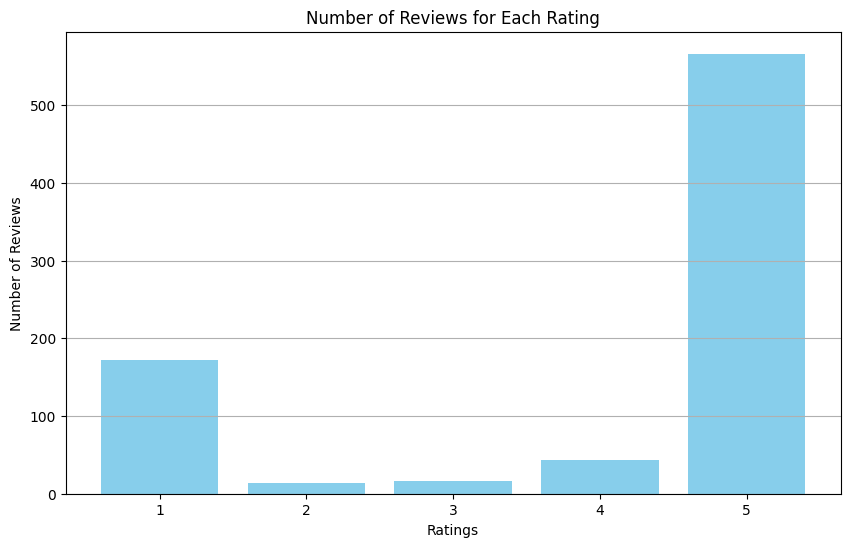

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

if 'review_rating' not in df.columns:
    raise ValueError("The dataset does not contain a 'rating' column.")

rating_counts = df['review_rating'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(rating_counts.index, rating_counts.values, color='skyblue')
plt.xlabel('Ratings')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews for Each Rating')
plt.xticks(range(1, 6))
plt.grid(axis='y')

plt.show()


PREPROCESSING TEXT

In [5]:
import string
import re
import json
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [6]:
def case_folding(sentence):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F700-\U0001F77F"  
        u"\U0001F780-\U0001F7FF"  
        u"\U0001F800-\U0001F8FF"  
        u"\U0001F900-\U0001F9FF"  
        u"\U0001FA00-\U0001FA6F"  
        u"\U0001FA70-\U0001FAFF"  
        u"\U0001F004-\U0001F0CF"  
        "]+", flags=re.UNICODE)

    sentence = emoji_pattern.sub(r'', sentence)
    sentence = sentence.translate(str.maketrans("","", string.punctuation)).lower()
    sentence = re.sub(r"\d+", "", sentence)
    sentence = sentence.replace("/", " ")
    return sentence

In [7]:
file = "abbreviation_file.txt"

def load_abbreviation_file(file):
    try:
        with open(file, "r") as file:
            abbreviations = json.load(file)
        return abbreviations
    except FileExistsError:
        print(f"File not found {file}")
        return {}

abbreviation_file = load_abbreviation_file(file)

def normalize_text(sentence):
    words = sentence.lower().split()
    words_normalized = []
    for word in words:
        for full_form, abbreviations in abbreviation_file.items():
            if word.lower() in abbreviations:
                words_normalized.append(full_form)
                break
        else:
            words_normalized.append(word)
    return " ".join(words_normalized)

In [12]:
def stopwords_removal(sentence):
    tokens = word_tokenize(sentence)
    liststopwords =  set(stopwords.words('indonesian'))
    custom_stopwords_file = "more_stopwords.txt"

    custom_stopwords = set()
    with open(custom_stopwords_file, "r") as file:
        for line in file:
            custom_stopwords.add(line.strip())

    combined_stopwords = liststopwords.union(custom_stopwords)

    with open(custom_stopwords_file, "w") as file:
        for word in combined_stopwords:
            file.write(word + "\n")
    return sentence

def remove_custom_stopwords(sentence, custom_stopwords_file):
    custom_stopwords = set()
    with open(custom_stopwords_file, 'r') as file:
        for line in file:
            custom_stopwords.add(line.strip())

    words = word_tokenize(sentence)
    filtered_words = [word for word in words if word.lower() not in custom_stopwords]
    cleaned_text = ' '.join(filtered_words)
    return cleaned_text

In [9]:
def stemming_text(sentence):
    factory = StemmerFactory()
    Stemmer = factory.create_stemmer()

    sentence = Stemmer.stem(sentence)
    return sentence

In [10]:
df['case_folding'] = df['review_text'].apply(case_folding)
df['normalized_text'] = df['case_folding'].apply(normalize_text)
df['stopword_removed'] = df['normalized_text'].apply(lambda x: remove_custom_stopwords(x, 'more_stopwords.txt'))
df['stemmed_text'] = df['stopword_removed'].apply(stemming_text)
pd.set_option('display.max_colwidth', None)
df.head(1)

,author_title,review_rating,review_text,case_folding,normalized_text,stopword_removed,stemmed_text
0,Felix zhang,5,"Urus KTP hilang cukup surat keterangan hilang dari kepolisian dan fotokopi KK\nAntrian sekitar 1 jam, proses cetak hanya sekitar 2 menit",urus ktp hilang cukup surat keterangan hilang dari kepolisian dan fotokopi kk\nantrian sekitar jam proses cetak hanya sekitar menit,urus kartu tanda penduduk hilang cukup surat keterangan hilang dari kepolisian dan fotokopi kartu keluarga antrian sekitar jam proses cetak hanya sekitar menit,urus kartu tanda penduduk hilang surat keterangan hilang kepolisian fotokopi kartu keluarga antrian jam proses cetak menit,urus kartu tanda duduk hilang surat terang hilang polisi fotokopi kartu keluarga antri jam proses cetak menit


TEXT ENCODING

In [14]:
import tensorflow
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import models

In [10]:
label_mapping = {1: 'Negative', 2: 'Negative', 3: 'Neutral', 4: 'Positive', 5: 'Positive'}

df_encoded = pd.DataFrame()
df_encoded['stemmed_text'] = df['stemmed_text']
df_encoded['sentiment_category'] = df['review_rating'].map(label_mapping)
df_encoded['sentiment_category'].fillna('Neutral', inplace=True)

label_encoder = LabelEncoder()
df_encoded['encoded_label'] = label_encoder.fit_transform(df_encoded['sentiment_category'])

df_encoded.head()

,stemmed_text,sentiment_category,encoded_label
0,urus kartu tanda duduk hilang surat terang hilang polisi fotokopi kartu keluarga antri jam proses cetak menit,Positive,2
1,urus akta nikah online taring denpasar proses cetak arah kantor informasi terima email cetak akta paket kartu tanda duduk kartu keluarga terbit admin wa taring denpasar respon tanggap cepat respect admin wa nya suasana dukcapil loket layan cepat ramah tunggu nyaman antri ramai paham alur astungkara mudah cepat,Positive,2
2,layan mana buat suratsurat mudah sistem online bulakbalik penuh dokumen langsung cetak mandiri bawa ojek online tugas ramah bimbing sulit moga layan tahan tingkat terimakasih,Positive,2
3,cocok gaji staf staf dukcapil kerja nya buru buru pulang jam salah salah cetak kartu tanda duduk kartu keluarga status agama kartu tanda duduk ganti buru buru pulang kerja beres,Negative,0
4,proses cepat online riweh bingung tinggal wa admin nya layan ramah ya beda sangtta yaa sih ter the best pokok,Positive,2


In [11]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded['stemmed_text'], df_encoded['encoded_label'], test_size=0.2, random_state=42)

In [12]:
max_words = 10000
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_length = 100  # Adjust based on your dataset
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

In [13]:
df_encoded['encoded_label'] = to_categorical(df_encoded['encoded_label'])
df_encoded.head()

,stemmed_text,sentiment_category,encoded_label
0,urus kartu tanda duduk hilang surat terang hilang polisi fotokopi kartu keluarga antri jam proses cetak menit,Positive,0.0
1,urus akta nikah online taring denpasar proses cetak arah kantor informasi terima email cetak akta paket kartu tanda duduk kartu keluarga terbit admin wa taring denpasar respon tanggap cepat respect admin wa nya suasana dukcapil loket layan cepat ramah tunggu nyaman antri ramai paham alur astungkara mudah cepat,Positive,0.0
2,layan mana buat suratsurat mudah sistem online bulakbalik penuh dokumen langsung cetak mandiri bawa ojek online tugas ramah bimbing sulit moga layan tahan tingkat terimakasih,Positive,0.0
3,cocok gaji staf staf dukcapil kerja nya buru buru pulang jam salah salah cetak kartu tanda duduk kartu keluarga status agama kartu tanda duduk ganti buru buru pulang kerja beres,Negative,1.0
4,proses cepat online riweh bingung tinggal wa admin nya layan ramah ya beda sangtta yaa sih ter the best pokok,Positive,0.0


MODEL CONFIGURATION

In [14]:
# Build model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_length))
model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=3, activation='softmax'))  # 3 output units for three categories

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
model.fit(X_train_padded, to_categorical(y_train), epochs=15, validation_data=(X_test_padded, to_categorical(y_test)))

Epoch 1/15
21/21 [==============================] - 2s 42ms/step - loss: 0.6917 - accuracy: 0.7103 - val_loss: 0.5764 - val_accuracy: 0.7485
Epoch 2/15
21/21 [==============================] - 1s 27ms/step - loss: 0.5007 - accuracy: 0.8243 - val_loss: 0.4783 - val_accuracy: 0.7975
Epoch 3/15
21/21 [==============================] - 1s 28ms/step - loss: 0.3476 - accuracy: 0.8937 - val_loss: 0.4101 - val_accuracy: 0.8712
Epoch 4/15
21/21 [==============================] - 1s 28ms/step - loss: 0.2341 - accuracy: 0.9353 - val_loss: 0.3719 - val_accuracy: 0.8773
Epoch 5/15
21/21 [==============================] - 1s 29ms/step - loss: 0.1581 - accuracy: 0.9599 - val_loss: 0.3747 - val_accuracy: 0.8589
Epoch 6/15
21/21 [==============================] - 1s 28ms/step - loss: 0.1150 - accuracy: 0.9723 - val_loss: 0.3552 - val_accuracy: 0.8773
Epoch 7/15
21/21 [==============================] - 1s 29ms/step - loss: 0.0872 - accuracy: 0.9738 - val_loss: 0.3496 - val_accuracy: 0.8896
Epoch 8/15
21

**SAVING THE MODEL IN ".h5"**

In [15]:
model.save('model.h5')
tokenizer_config = tokenizer.get_config()
tokenizer_config['num_words'] = max_words
with open('tokenizer_config.json', 'w') as config_file:
    config_file.write(json.dumps(tokenizer_config))